##  Optimze and a Dense Neural Network for gap filling and feature identification

** With a few tweaks to RepRunner, an LSTM can be run instead

In [1]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

from itertools import combinations
from functools import partial

from multiprocessing import Pool

from scipy.stats import norm
from scipy import stats

# from sklearn.preprocessing import StandardScaler
from sklearn import metrics
# from sklearn.model_selection import RepeatedKFold, WhiteKernel, ConstantKernel

## Personal Modules
import ReadStandardTimeFill as RSTF
import RepRunner as RR
# import LSTM
import Dense

import importlib
# importlib.reload(LSTM)
# importlib.reload(Dense)
importlib.reload(RR)
# importlib.reload(RSTF)

%matplotlib inline
%config IPCompleter.greedy=True

# pool.close()

In [2]:

Path = 'Data_Footprints_2018-05-10.csv'

FillVar = 'fch4'

FP_Model = ['Grass','Water','Shrub','Sedge','Sparse','Upland',
     'Ocean','Fen','Out_of_Basin'] 

Net = RR.Network(Path,'Test',FillVar,FP_Model,MP=False)# rpms.Runs,rpms.params
print(Net.Runs)

     N  MSE  STD   CI  Upper_Bounds  Lower_Bounds
0   50  0.0  0.0  0.0           0.0           0.0
1   75  0.0  0.0  0.0           0.0           0.0
2  100  0.0  0.0  0.0           0.0           0.0


Using TensorFlow backend.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Finished Run  0  MSE:  0.716003817543
Finished Run  1  MSE:  0.70028629222
Finished Run  2  MSE:  0.685676264522


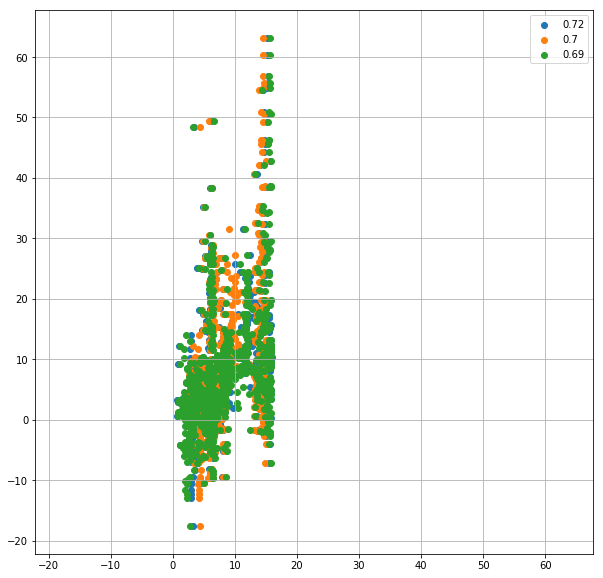

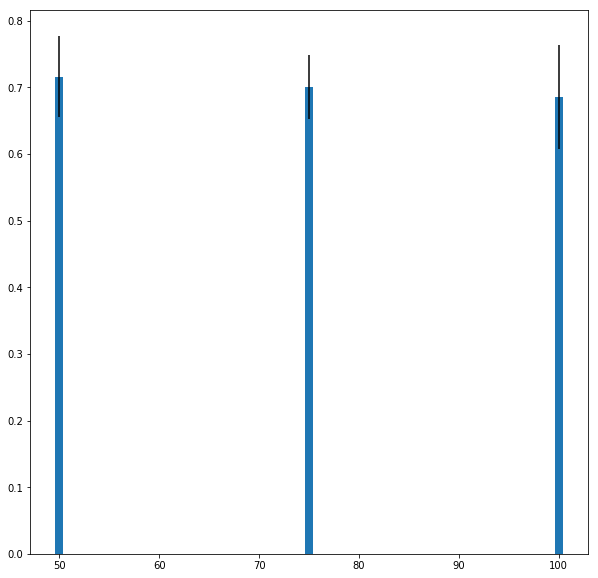

In [4]:
Time = time.time()

plt.figure(figsize=(10,10))

if __name__=='__main__' and Net.params['proc'] != 1:
    pool = Pool(processes=Net.params['proc'],maxtasksperchild=75)
else:pool=None
    
for i in Net.Runs.index:
    try:
        Net.params['T']=Net.Runs['T'].iloc[i]
    except:
        Net.params['T'] = 0
    Net.params['N']=Net.Runs['N'].iloc[i]
    Results = Net.RunReps(pool,plot=True)
    MSE = Results[0]
    Net.Runs['MSE'][i]=MSE.mean()
    Net.Runs['STD'][i]=MSE.std()
    print('Finished Run ',str(i),' MSE: ',MSE.mean())

plt.grid()
plt.legend()
Net.Runs['CI'] = Net.Runs['STD']/Net.params['reps']**.5*stats.t.ppf(1-0.05, Net.params['reps']-2)
try:
    plt.figure(figsize=(10,10))
    plt.scatter(Net.Runs['N'],Net.Runs['T'],c = Net.Runs['MSE'],s=Net.Runs['STD']*1e4)
except:
    plt.figure(figsize=(10,10))
    plt.bar(Net.Runs['N'],Net.Runs['MSE'],yerr=Net.Runs['CI'])
    

In [5]:
Net.GP(pool)

96


C:\Users\wesle\ML_GapFilling\RepRunner.py:212: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.Runs['MSE'][idx]=MSE.mean()
C:\Users\wesle\ML_GapFilling\RepRunner.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.Runs['STD'][idx]=MSE.std()


NameError: name 'Net' is not defined

In [ ]:
try:
    plt.figure(figsize=(10,10))
    plt.scatter(Net.Runs['N'],Net.Runs['T'],c = Net.Runs['MSE'],s=Net.Runs['STD']*1e4)
except:
    plt.figure(figsize=(10,10))
    plt.bar(Net.Runs['N'],Net.Runs['MSE'],yerr=Net.Runs['CI'])
    
plt.grid()
print(Net.Runs)
Optimum = Net.Runs[Net.Runs['Lower_Bounds'] <= Net.Runs['Upper_Bounds'].min()]
# print(Optimum)
Optimum = Optimum[Optimum['N'] == Optimum['N'].min()]

print('Optimum:')
print(Optimum)


# Feature Identification

In [ ]:
BestMSE = []
BestSTD = []
idx = []
BestModels = []

def Combos(Model,L,factor=None):
    Models=list()
    for c in combinations(Model,L):
        c = list(c)
        if factor is None:
            Models.append(c)
        else:
            for f in factor:
                f = f.split('+')
                if set(f).issubset(set(c)) and c not in Models:
                    Models.append(c)
    print (Models)
    return(Models)
try:
    params['T']=Optimum['T'].values[0]
except:
    pass
params['N']=Optimum['N'].values[0]
# print(Optimum)

FullModel = params['Model']


print(FullModel)
Scores = Optimum[['MSE','CI','Upper_Bounds','STD']].reset_index(drop=True)
Scores['Level'] = len(FullModel)
Scores['Key'] = str(Scores['Level'][0])+'_0'
Scores['Model'] = '+'.join(FullModel)
# print(Scores)



Results = RR.RunReps(params,pool)
ModelRuns = Results[1]
ModelRuns = ModelRuns.to_frame()
ModelRuns.rename(columns={'TempFill':'+'.join(FullModel)})
# print(ModelRuns)

for i in range(1,len(FullModel)):
    print('Level: ',i)
    if i == 1:
        Models = Combos(FullModel,i)
    else:
        Models = Combos(FullModel,i,factor = Best)
#     Score = []
#     STD = []
#     Model_Names = []
    
    for i,model in enumerate(Models):
        NewRow = Scores.iloc[-1].copy()
        NewRow['Model'] = 'Model: '+'+'.join(model)
        params['Model'] = model
        Results = RR.RunReps(params,pool)
        MSE = Results[0]
        mean,std = MSE.mean(),MSE.std()
        CI = std/params['reps']**.5*stats.t.ppf(1-0.05, params['reps']-1)
        level = len(model)
        key = str(level)+'_'+str(i)
        d = {'Model':'+'.join(model),
             'MSE':mean,'STD':std,'Level':level,
             'CI':CI,'Upper_Bounds':mean+CI,
                'Key':key}
        score = pd.DataFrame(index=[0],data=d)
        print(model,' Upper Bound ',mean+CI)
        Scores = Scores.append(score,ignore_index=True)
        ModelRuns['Model: '+'+'.join(model)] = Results[1]
        
    Level = Scores.loc[Scores['Level'] == level]
    Lowest_Yet = Scores.loc[Scores['Level']<= level]['Upper_Bounds'].min()
    Best = Level.loc[Level['MSE']<=Lowest_Yet]['Model'].values
    print(Best)
#     print(ModelRuns)
#         print(model,MSE)
#         Score.append(MSE.mean())
#         STD.append(MSE.std())
#         Model_Names.append('Model: '+'+'.join(model))
        
#     Score = np.asanyarray(Score)
#     STD = np.asanyarray(STD)
#     Best = Models[np.where(Score == Score.min())[0][0]]
#     Best_Name = Model_Names[np.where(Score == Score.min())[0][0]]
#     BestModels.append(Best_Name)
#     BestMSE.append(Score.min())
#     BestSTD.append(STD[np.where(Score == Score.min())[0][0]])
#     idx.append(i)
#     print('Best:')
#     print(Best,Score.min())
# BestModels = np.asanyarray(BestModels)
# BestMSE = np.asanyarray(BestMSE)
# BestSTD = np.asanyarray(BestSTD)
# idx = np.asanyarray(idx)
# BestSE = BestSTD/(params['reps']**.5)
# BestCI = BestSE*1.96
# plt.figure(figsize=(10,10))
# plt.bar(idx,BestMSE)
# plt.errorbar(idx,BestMSE,yerr=BestCI,color = 'black',fmt='o')

# d = {'Models':BestModels,'MSE':BestMSE,'CI':BestCI}
# Stats = pd.DataFrame(index=idx,data=d)
Scores.to_csv('GapFillingSummary'+FillVar+'.csv')
# print(Stats)

ModelRuns.to_csv('GapFilled'+FillVar+'.csv')



In [ ]:

if __name__=='__main__'and params['proc'] != 1:
    pool.close()

print(time.time()-Time)
        